In [1]:
import pandas as pd
import data_work 
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
%matplotlib inline




In [2]:
df = data_work.load_data()
df = data_work.clean_values(df)

summary = data_work.summary_calculations(df)

df_detail = data_work.detail_calculations(df)

df_time = df_detail.reset_index()
df_time['year'] = df_time['due_date'].dt.year
df_time['month'] = df_time['due_date'].dt.month

In [3]:
df_time

,due_date,customer_id,contract_id,deposit,amt_due,company,sector,industry,email,address,city,state,zip,year,month
0,2019-01-01,20,60,False,11900.0,Omba,NaN,NaN,ctreblej@ifeng.com,2120 Kensington Center,Seattle,WA,98185,2019,1
1,2019-01-01,90,392,True,67000.0,Brightbean,Health Care,Biotechnology: Biological Products (No Diagnos...,ncoaten2h@altervista.org,11712 Elgar Center,Portland,OR,97206,2019,1
2,2019-01-01,90,392,False,7700.0,Brightbean,Health Care,Biotechnology: Biological Products (No Diagnos...,ncoaten2h@altervista.org,11712 Elgar Center,Portland,OR,97206,2019,1
3,2019-01-01,168,627,True,78000.0,Leenti,Consumer Services,Television Services,ndoone4n@go.com,471 Northwestern Way,Cincinnati,OH,45208,2019,1
4,2019-01-01,168,627,False,18700.0,Leenti,Consumer Services,Television Services,ndoone4n@go.com,471 Northwestern Way,Cincinnati,OH,45208,2019,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13143,2021-09-14,4,378,False,15700.0,Viva,Health Care,Major Pharmaceuticals,wgiovanitti3@nytimes.com,074 Center Place,Topeka,KS,66667,2021,9
13144,2021-09-14,107,974,False,19900.0,Flashset,Health Care,Medical Specialities,mstummeyer2y@npr.org,236 Weeping Birch Parkway,Dallas,TX,75216,2021,9
13145,2021-09-25,183,364,False,18600.0,Bubblebox,Finance,Major Banks,kklageman52@about.me,6298 Maryland Center,Erie,PA,16510,2021,9
13146,2021-09-25,172,43,False,19700.0,Brainsphere,Health Care,Medical/Dental Instruments,sassur4r@bloglovin.com,5881 Ruskin Circle,Portland,OR,97206,2021,9


In [4]:
df_detail.tail()

,customer_id,contract_id,deposit,amt_due,company,sector,industry,email,address,city,state,zip
due_date,,,,,,,,,,,,
2021-09-14,4,378,False,15700.0,Viva,Health Care,Major Pharmaceuticals,wgiovanitti3@nytimes.com,074 Center Place,Topeka,KS,66667
2021-09-14,107,974,False,19900.0,Flashset,Health Care,Medical Specialities,mstummeyer2y@npr.org,236 Weeping Birch Parkway,Dallas,TX,75216
2021-09-25,183,364,False,18600.0,Bubblebox,Finance,Major Banks,kklageman52@about.me,6298 Maryland Center,Erie,PA,16510
2021-09-25,172,43,False,19700.0,Brainsphere,Health Care,Medical/Dental Instruments,sassur4r@bloglovin.com,5881 Ruskin Circle,Portland,OR,97206
2021-10-04,29,509,False,9400.0,Yodoo,NaN,NaN,lwinstanleys@noaa.gov,3 Oneill Court,Tucson,AZ,85715


<AxesSubplot:xlabel='due_date'>

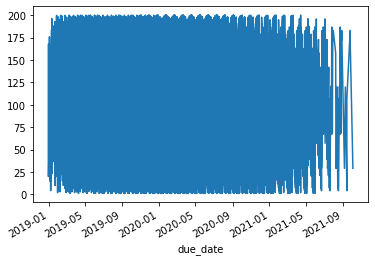

In [5]:
df_detail['customer_id'].plot()

<AxesSubplot:xlabel='due_date'>

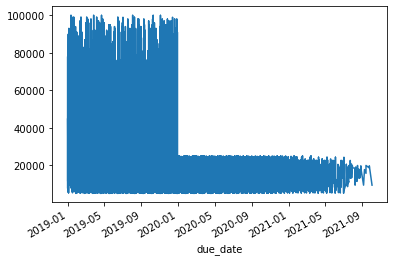

In [6]:
df_detail['amt_due'].plot()

<AxesSubplot:xlabel='due_date'>

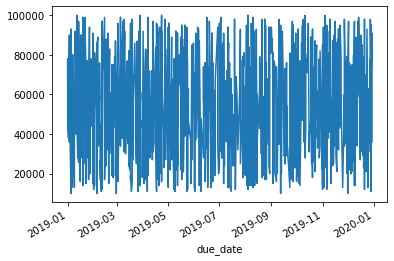

In [7]:
df_detail.loc[df_detail['deposit'], 'amt_due'].plot()

<AxesSubplot:xlabel='due_date'>

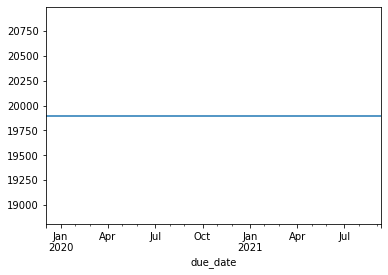

In [8]:
df_detail.loc[(
    (df_detail['deposit'] == False) &
    (df_detail['contract_id'] == 974)
), 'amt_due'].plot()

<AxesSubplot:xlabel='due_date'>

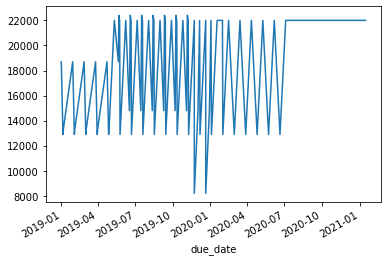

In [9]:
df_detail.loc[(
    (df_detail['deposit'] == False) &
    (df_detail['industry'] == 'Television Services')
), 'amt_due'].plot()

In [10]:
df_detail.groupby('state').agg({'amt_due':'sum'}).plot.bar(y = 'amt_due', x= 'state')

KeyError: 'state'

<AxesSubplot:xlabel='state'>

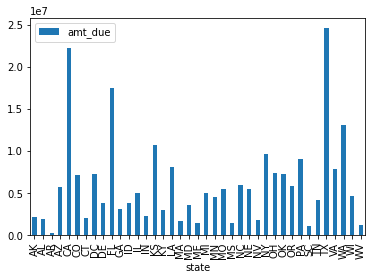

In [11]:
df_detail.groupby('state', as_index=False).agg({'amt_due':'sum'}).plot.bar(y = 'amt_due', x= 'state')

<AxesSubplot:xlabel='state'>

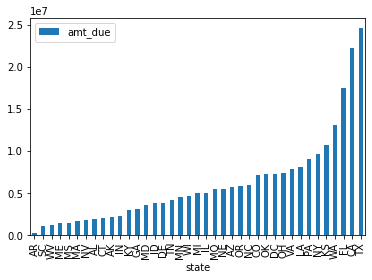

In [12]:
df_detail.groupby('state', as_index=False).agg({'amt_due':'sum'}).sort_values('amt_due').plot.bar(y = 'amt_due', x= 'state')


In [13]:
df_v = df_detail.reset_index()
df_v['year'] = df_v['due_date'].dt.year
df_v['month'] = df_v['due_date'].dt.month
df_v.head()

,due_date,customer_id,contract_id,deposit,amt_due,company,sector,industry,email,address,city,state,zip,year,month
0,2019-01-01,20,60,False,11900.0,Omba,NaN,NaN,ctreblej@ifeng.com,2120 Kensington Center,Seattle,WA,98185,2019,1
1,2019-01-01,90,392,True,67000.0,Brightbean,Health Care,Biotechnology: Biological Products (No Diagnos...,ncoaten2h@altervista.org,11712 Elgar Center,Portland,OR,97206,2019,1
2,2019-01-01,90,392,False,7700.0,Brightbean,Health Care,Biotechnology: Biological Products (No Diagnos...,ncoaten2h@altervista.org,11712 Elgar Center,Portland,OR,97206,2019,1
3,2019-01-01,168,627,True,78000.0,Leenti,Consumer Services,Television Services,ndoone4n@go.com,471 Northwestern Way,Cincinnati,OH,45208,2019,1
4,2019-01-01,168,627,False,18700.0,Leenti,Consumer Services,Television Services,ndoone4n@go.com,471 Northwestern Way,Cincinnati,OH,45208,2019,1


<AxesSubplot:xlabel='year,month'>

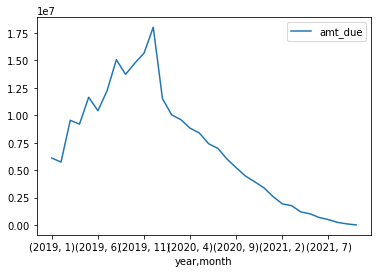

In [14]:
df_v.groupby(['year', 'month']).agg({'amt_due':sum}).plot()

<AxesSubplot:xlabel='year,month'>

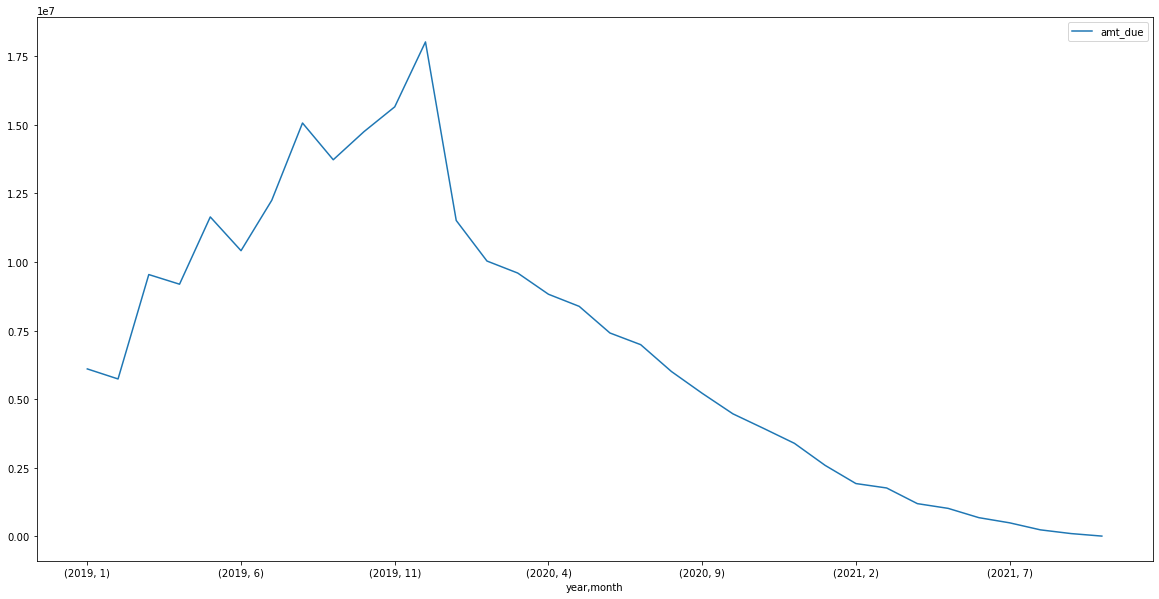

In [15]:
df_v.groupby(['year', 'month']).agg({'amt_due':sum}).plot(figsize=(30, 15))

(array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35.]),
 [Text(-5.0, 0, '(2021, 6)'),
  Text(0.0, 0, '(2019, 1)'),
  Text(5.0, 0, '(2019, 6)'),
  Text(10.0, 0, '(2019, 11)'),
  Text(15.0, 0, '(2020, 4)'),
  Text(20.0, 0, '(2020, 9)'),
  Text(25.0, 0, '(2021, 2)'),
  Text(30.0, 0, '(2021, 7)'),
  Text(35.0, 0, '')])

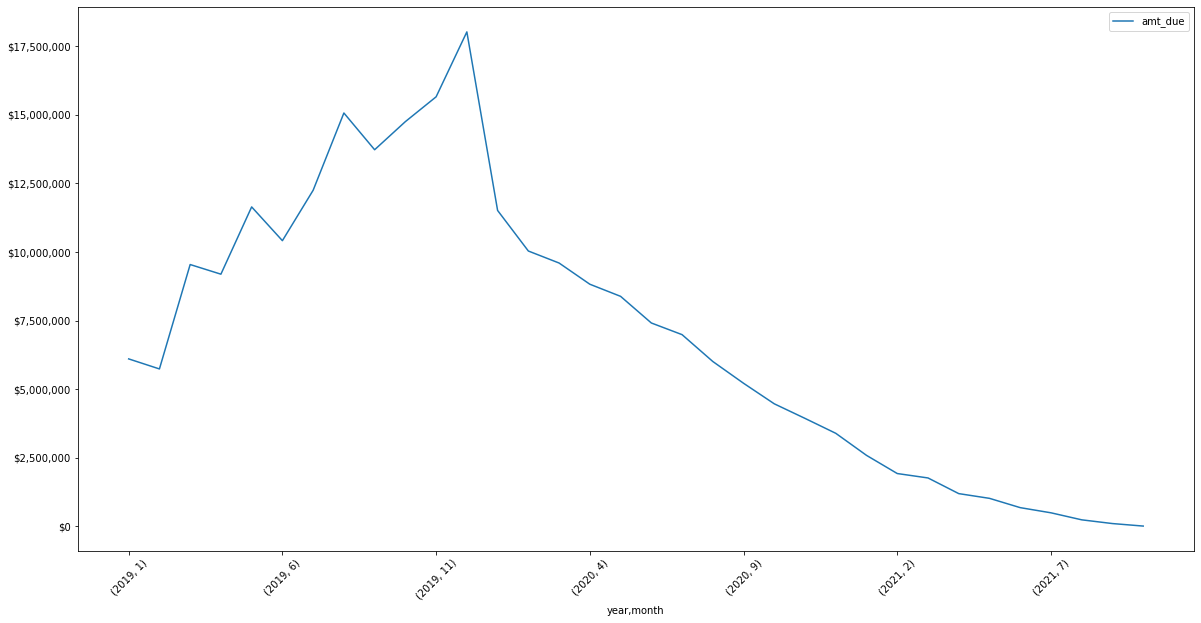

In [16]:
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)

df_v.groupby(['year', 'month']).agg({'amt_due':sum}).plot(figsize=(25, 10)).yaxis.set_major_formatter(tick)
plt.xticks(rotation=45)